<a href="https://colab.research.google.com/github/rezapci/IBM-Coursera-Capstone-Project-Notebook/blob/master/Second_Part_Clustering_London's_Most_Typical_Venues_By_Neighborhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Name | Description | Date
| :- |-------------: | :-:
|Reza Hashemi| IBM Applied Data Science Capstone.  | On 6th of August 2019

# Introduction

As the first part of this project to find the optimal location for an Indian restaurant in London. It is first needed to analyze the city's most typical venues by neighborhood, so it is possible to have an idea of which are the actual leisure places where people go spend their time. To begin this analysis, neighborhood clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood get extracted, for the second part of this project a segmentation by nationality of the people living in each neighborhood will be carried out, in order to determine in which neighborhood would be more advisable to open a Indian food restaurant based on the results of the previous segmentation and the analised venues.

For this project, the data that will be used to analyse the venues comes from the Foursquare API and the Wikipedia's Ethnic groups in London webpage. This project will be devoloped using the Python 3.6 programing language as the main working tool. To have access to the data used in this part, please refer to the first notebook: "Optimal location for an Indian restaurant". The data used in this motebook must be generated in the first notebook.

### Import necessary Libraries

In [0]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Read and explore the data

In [0]:
df = pd.read_csv('London population.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

London Borough  Indian Population  Pakistani Population  \
0         Newham              42484                 30307   
1      Redbridge              45660                 31051   
2          Brent              58017                 14381   
3  Tower Hamlets               6787                  2442   
4         Harrow              63051                  7797   

   Bangladeshi Population  Chinese Population  Other Asian Population  \
0                   37262                3930                   19912   
1                   16011                3000                   20781   
2                    1749                3250                   28589   
3                   81377                8109                    5786   
4                    1378                2629                   26953   

   Total Asian Population  
0                  133895  
1                  116503  
2                  105986  
3                  104501  
4                  101808

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
London Borough            20 non-null object
Indian Population         20 non-null int64
Pakistani Population      20 non-null int64
Bangladeshi Population    20 non-null int64
Chinese Population        20 non-null int64
Other Asian Population    20 non-null int64
Total Asian Population    20 non-null int64
dtypes: int64(6), object(1)
memory usage: 1.2+ KB


In [0]:
df.isnull().sum()

London Borough            0
Indian Population         0
Pakistani Population      0
Bangladeshi Population    0
Chinese Population        0
Other Asian Population    0
Total Asian Population    0
dtype: int64

### Create a new dataframe with the coordinates of London's neighborhoods

In [0]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Newham', 'Redbridge', 'Brent', 'Tower Hamlets', 'Harrow',
                'Ealing', 'Hounslow', 'Hillingdon', 'Barnet', 'Croydon', 'Waltham Forest',
                'Merton', 'Camden', 'Enfield', 'Wandsworth', 'Westminster', 'Greenwich',
                'Barking and Dagenham', 'Southwark', 'Kingston Upon Thames'],
'Latitude' : ['51.5255','51.5901','51.5673','51.5203','51.5806','51.5131','51.4609','51.5352','51.6251','51.3762','51.5886',
             '51.4098','51.5517','51.6636','51.4571','51.4975','51.4934','51.5465','51.4834','51.4123'],
'Longitude' : ['0.0352','0.0819','-0.2711','-0.0293','-0.3420','-0.3256','-0.3731','-0.4481','-0.1529','-0.0982','-0.0118',
              '-0.2108','-0.1588','-0.1043','-0.1818','-0.1357','0.0098','0.1293','-0.0821','-0.3007']})

In [0]:
coordinates_df.head()

Neighborhood Latitude Longitude
0         Newham  51.5255    0.0352
1      Redbridge  51.5901    0.0819
2          Brent  51.5673   -0.2711
3  Tower Hamlets  51.5203   -0.0293
4         Harrow  51.5806   -0.3420

In [0]:
coordinates_df.info

<bound method DataFrame.info of             Neighborhood Latitude Longitude
0                 Newham  51.5255    0.0352
1              Redbridge  51.5901    0.0819
2                  Brent  51.5673   -0.2711
3          Tower Hamlets  51.5203   -0.0293
4                 Harrow  51.5806   -0.3420
5                 Ealing  51.5131   -0.3256
6               Hounslow  51.4609   -0.3731
7             Hillingdon  51.5352   -0.4481
8                 Barnet  51.6251   -0.1529
9                Croydon  51.3762   -0.0982
10        Waltham Forest  51.5886   -0.0118
11                Merton  51.4098   -0.2108
12                Camden  51.5517   -0.1588
13               Enfield  51.6636   -0.1043
14            Wandsworth  51.4571   -0.1818
15           Westminster  51.4975   -0.1357
16             Greenwich  51.4934    0.0098
17  Barking and Dagenham  51.5465    0.1293
18             Southwark  51.4834   -0.0821
19  Kingston Upon Thames  51.4123   -0.3007>

In [0]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

### Get latitudes and longitudes of London

In [0]:
address = 'London, London'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinates of London are 51.5073219, -0.1276474.


### Create a map of London with its neighbourhoods

In [0]:
London_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(London_map)  
    
London_map

### Explore the Neighborhoods with Foursquare data

##### Define Foursquare credentials and version

In [0]:
CLIENT_ID = 'YG1TKWPHECOQQWLO3ICSIAXBQLVX24ZNVC1XRADRCXCNQFLC' # Foursquare ID
CLIENT_SECRET = 'V0MK3UMF1MN4N3F4W1O1BDVDMAMU0LC5T4QVNANSXS5T5XUY' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: YG1TKWPHECOQQWLO3ICSIAXBQLVX24ZNVC1XRADRCXCNQFLC
CLIENT_SECRET:V0MK3UMF1MN4N3F4W1O1BDVDMAMU0LC5T4QVNANSXS5T5XUY


### Get the first Neighborhood's name

In [0]:
coordinates_df.loc[0, 'Neighborhood']

'Newham'

Now let's get the latitude and longitude of this neighborhood

In [0]:
neighborhood_latitude = coordinates_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = coordinates_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = coordinates_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Newham are 51.5255, 0.0352.


### Get the top 100 venues in Newham in a radius of 500 metters

In [0]:
LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [0]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d3bf36cbf7dde002c6ad0cd'},
 'response': {'headerLocation': 'Newham',
  'headerFullLocation': 'Newham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 51.5300000045, 'lng': 0.04241929604043637},
   'sw': {'lat': 51.5209999955, 'lng': 0.027980703959563636}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e7b2628887783148edecd7d',
       'name': 'Delicious Café',
       'location': {'address': '566 Barking Road',
        'lat': 51.526416732217484,
        'lng': 0.030133265936175827,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.526416732217484,
          'lng': 0.030133265936175827}],
        'distance': 365,
        'postalCode': 'E13 9JU',
      

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [0]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name         categories        lat       lng
0              Delicious Café               Café  51.526417  0.030133
1               Tesco Express      Grocery Store  51.527187  0.035118
2                 Andre Moves       Home Service  51.524192  0.036145
3  Deep Blue Sea Fish & Chips  Fish & Chips Shop  51.525097  0.039410
4        Ginny's Pie and Mash               Café  51.525705  0.029532

In [0]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


### Now we are going to create a function that repeats all the above process for all the neighborhoods in London, so we can explore these neighborhoods in more depth

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
London_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )


Newham
Redbridge
Brent
Tower Hamlets
Harrow
Ealing
Hounslow
Hillingdon
Barnet
Croydon
Waltham Forest
Merton
Camden
Enfield
Wandsworth
Westminster
Greenwich
Barking and Dagenham
Southwark
Kingston Upon Thames


### Check the size of our new df

In [0]:
print(London_venues.shape)
London_venues.head()

(402, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Newham                51.5255                  0.0352   
1       Newham                51.5255                  0.0352   
2       Newham                51.5255                  0.0352   
3       Newham                51.5255                  0.0352   
4       Newham                51.5255                  0.0352   

                        Venue  Venue Latitude  Venue Longitude  \
0              Delicious Café       51.526417         0.030133   
1               Tesco Express       51.527187         0.035118   
2                 Andre Moves       51.524192         0.036145   
3  Deep Blue Sea Fish & Chips       51.525097         0.039410   
4        Ginny's Pie and Mash       51.525705         0.029532   

      Venue Category  
0               Café  
1      Grocery Store  
2       Home Service  
3  Fish & Chips Shop  
4               Café

### How many venues are there by neighborhood?

In [0]:
London_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                 
Barking and Dagenham                      2                       2      2   
Barnet                                    3                       3      3   
Brent                                     7                       7      7   
Camden                                   25                      25     25   
Croydon                                  59                      59     59   
Ealing                                   23                      23     23   
Enfield                                   5                       5      5   
Greenwich                                23                      23     23   
Harrow                                   26                      26     26   
Hillingdon                                5                       5      5   
Hounslow                                  5                       5      5   
Kingston Upon Thames                     81                      81     81   
Merton                                   14                      14     14   
Newham                                    7                       7      7   
Redbridge                                15                      15     15   
Southwark                                 6                       6      6   
Tower Hamlets                            13                      13     13   
Waltham Forest                           15                      15     15   
Wandsworth                               13                      13     13   
Westminster                              55                      55     55   

                      Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                           
Barking and Dagenham               2                2               2  
Barnet                             3                3               3  
Brent                              7                7               7  
Camden                            25               25              25  
Croydon                           59               59              59  
Ealing                            23               23              23  
Enfield                            5                5               5  
Greenwich                         23               23              23  
Harrow                            26               26              26  
Hillingdon                         5                5               5  
Hounslow                           5                5               5  
Kingston Upon Thames              81               81              81  
Merton                            14               14              14  
Newham                             7                7               7  
Redbridge                         15               15              15  
Southwark                          6                6               6  
Tower Hamlets                     13               13              13  
Waltham Forest                    15               15              15  
Wandsworth                        13               13              13  
Westminster                       55               55              55

### Let's now analyze our neighborhoods

In [0]:
# one hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

Neighborhood  American Restaurant  Art Gallery  Arts & Crafts Store  \
0       Newham                    0            0                    0   
1       Newham                    0            0                    0   
2       Newham                    0            0                    0   
3       Newham                    0            0                    0   
4       Newham                    0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0                 0                   0            0              0   
1                 0                   0            0              0   
2                 0                   0            0              0   
3                 0                   0            0              0   
4                 0                   0            0              0   

   Bagel Shop  Bakery  Bar  Bistro  Bookstore  Breakfast Spot  Brewery  \
0           0       0    0       0          0               0        0   
1           0       0    0       0          0               0        0   
2           0       0    0       0          0               0        0   
3           0       0    0       0          0               0        0   
4           0       0    0       0          0               0        0   

   Building  Burger Joint  Burrito Place  Bus Station  Bus Stop  \
0         0             0              0            0         0   
1         0             0              0            0         0   
2         0             0              0            0         0   
3         0             0              0            0         0   
4         0             0              0            0         0   

   Business Service  Café  Canal Lock  Caribbean Restaurant  \
0                 0     1           0                     0   
1                 0     0           0                     0   
2                 0     0           0                     0   
3                 0     0           0                     0   
4                 0     1           0                     0   

   Chinese Restaurant  Chocolate Shop  Clothing Store  Cocktail Bar  \
0                   0               0               0             0   
1                   0               0               0             0   
2                   0               0               0             0   
3                   0               0               0             0   
4                   0               0               0             0   

   Coffee Shop  Concert Hall  Construction & Landscaping  Convenience Store  \
0            0             0                           0                  0   
1            0             0                           0                  0   
2            0             0                           0                  0   
3            0             0                           0                  0   
4            0             0                           0                  0   

   Cosmetics Shop  Deli / Bodega  Department Store  Dessert Shop  Diner  \
0               0              0                 0             0      0   
1               0              0                 0             0      0   
2               0              0                 0             0      0   
3               0              0                 0             0      0   
4               0              0                 0             0      0   

   Doner Restaurant  Donut Shop  Electronics Store  Falafel Restaurant  \
0                 0           0                  0                   0   
1                 0           0                  0                   0   
2                 0           0                  0                   0   
3                 0           0                  0                   0   
4                 0           0                  0                   0   

   Farmers Market  Fast Food Restaurant  Field  Fish & Chips Shop  \
0               0                     0   

In [0]:
london_onehot.shape

(402, 125)

### Group by neighborhood and get the mean ocurrence of each venue category

In [0]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

Neighborhood  American Restaurant  Art Gallery  \
0   Barking and Dagenham             0.000000     0.000000   
1                 Barnet             0.000000     0.000000   
2                  Brent             0.000000     0.000000   
3                 Camden             0.040000     0.000000   
4                Croydon             0.000000     0.000000   
5                 Ealing             0.000000     0.000000   
6                Enfield             0.000000     0.000000   
7              Greenwich             0.000000     0.000000   
8                 Harrow             0.000000     0.000000   
9             Hillingdon             0.000000     0.000000   
10              Hounslow             0.000000     0.000000   
11  Kingston Upon Thames             0.012346     0.000000   
12                Merton             0.000000     0.000000   
13                Newham             0.000000     0.000000   
14             Redbridge             0.000000     0.000000   
15             Southwark             0.000000     0.000000   
16         Tower Hamlets             0.000000     0.076923   
17        Waltham Forest             0.000000     0.000000   
18            Wandsworth             0.000000     0.000000   
19           Westminster             0.000000     0.000000   

    Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0              0.000000          0.000000            0.000000          0.0   
1              0.000000          0.000000            0.000000          0.0   
2              0.000000          0.000000            0.000000          0.0   
3              0.000000          0.000000            0.000000          0.0   
4              0.000000          0.033898            0.000000          0.0   
5              0.000000          0.000000            0.000000          0.0   
6              0.000000          0.000000            0.000000          0.0   
7              0.000000          0.043478            0.000000          0.0   
8              0.000000          0.000000            0.000000          0.0   
9              0.000000          0.000000            0.000000          0.0   
10             0.000000          0.000000            0.000000          0.2   
11             0.012346          0.000000            0.000000          0.0   
12             0.000000          0.000000            0.000000          0.0   
13             0.000000          0.000000            0.000000          0.0   
14             0.000000          0.000000            0.066667          0.0   
15             0.000000          0.000000            0.000000          0.0   
16             0.000000          0.000000            0.000000          0.0   
17             0.000000          0.000000            0.000000          0.0   
18             0.000000          0.000000            0.000000          0.0   
19             0.000000          0.018182            0.000000          0.0   

    Auto Workshop  Bagel Shop    Bakery       Bar    Bistro  Bookstore  \
0             0.0    0.000000  0.000000  0.000000  0.000000   0.000000   
1             0.0    0.000000  0.000000  0.000000  0.000000   0.000000   
2             0.0    0.000000  0.000000  0.000000  0.000000   0.000000   
3             0.0    0.000000  0.080000  0.000000  0.000000   0.040000   
4             0.0    0.000000  0.000000  0.016949  0.000000   0.050847   
5             0.0    0.043478  0.043478  0.000000  0.000000   0.000000   
6             0.2    0.000000  0.000000  0.000000  0.000000   0.000000   
7             0.0    0.000000  0.000000  0.000000  0.000000   0.000000   
8             0.0    0.000000  0.000000  0.000000  0.000000   0.038462   
9             0.0    0.000000  0.200000  0.000000  0.000000   0.000000   
10            0.0    0.000000  0.000000  0.000000  0.000000   0.000000   
11            0.0    0.000000  0.037037  0.012346  0.000000   0.037037   
12            0.0    0.000000  0.071429  0.000000  0.000000   0.000000   
13            0.0    0.000000  0.0

In [0]:
london_grouped.shape

(20, 125)

### 5 top venues by neighborhood

In [0]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                 venue  freq
0                 Lake   0.5
1                 Park   0.5
2  American Restaurant   0.0
3               Museum   0.0
4           Public Art   0.0


----Barnet----
                 venue  freq
0                 Café  0.67
1             Bus Stop  0.33
2  American Restaurant  0.00
3    Recreation Center  0.00
4           Public Art  0.00


----Brent----
                  venue  freq
0           Bus Station  0.14
1  Fast Food Restaurant  0.14
2                  Café  0.14
3            Food Truck  0.14
4              Bus Stop  0.14


----Camden----
         venue  freq
0  Coffee Shop  0.08
1    Gastropub  0.08
2       Bakery  0.08
3  Pizza Place  0.08
4         Café  0.08


----Croydon----
            venue  freq
0     Coffee Shop  0.20
1        Platform  0.12
2  Clothing Store  0.10
3             Pub  0.05
4       Bookstore  0.05


----Ealing----
                  venue  freq
0                 Hotel  0.13
1  Fast Food Restaurant  0.0

### Function to sort the venues in descending order

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's put this into a new pandas df and show the top ten venues per neighborhood

In [0]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood      1st Most Common Venue 2nd Most Common Venue  \
0   Barking and Dagenham                       Lake                  Park   
1                 Barnet                       Café              Bus Stop   
2                  Brent                Supermarket           IT Services   
3                 Camden                  Gastropub                Bakery   
4                Croydon                Coffee Shop              Platform   
5                 Ealing                      Hotel  Fast Food Restaurant   
6                Enfield                        Pub           Coffee Shop   
7              Greenwich                       Park    Chinese Restaurant   
8                 Harrow                Coffee Shop        Clothing Store   
9             Hillingdon                     Bakery    Chinese Restaurant   
10              Hounslow  Middle Eastern Restaurant           Auto Garage   
11  Kingston Upon Thames                       Café           Coffee Shop   
12                Merton              Grocery Store                Bakery   
13                Newham              Grocery Store                  Café   
14             Redbridge                Supermarket                   Pub   
15             Southwark                        Pub              Building   
16         Tower Hamlets                Coffee Shop         Track Stadium   
17        Waltham Forest              Grocery Store                   Pub   
18            Wandsworth                        Pub         Grocery Store   
19           Westminster                      Hotel           Coffee Shop   

         3rd Most Common Venue 4th Most Common Venue  \
0                Women's Store            Food Court   
1                Women's Store        Cosmetics Shop   
2                  Bus Station            Food Truck   
3                  Pizza Place           Coffee Shop   
4               Clothing Store                   Pub   
5                  Supermarket         Grocery Store   
6                   Restaurant         Auto Workshop   
7               Ice Cream Shop               Brewery   
8                  Pizza Place                   Gym   
9   Construction & Landscaping     Martial Arts Dojo   
10                 Pizza Place         Grocery Store   
11              Clothing Store                Bakery   
12                        Café                  Park   
13           Fish & Chips Shop          Home Service   
14                    Pharmacy  Fast Food Restaurant   
15                        Café            Skate Park   
16   Middle Eastern Restaurant            Canal Lock   
17                 Coffee Shop          Concert Hall   
18                        Café           Coffee Shop   
19              Sandwich Place      Sushi Restaurant   

            5th Most Common Venue 6th Most Common Venue  \
0                Department Store          Dessert Shop   
1                Department Store          Dessert Shop   
2                        Bus Stop                  Café   
3                            Café   American Restaurant   
4                       Bookstore                 Hotel   
5                     Coffee Shop                Bakery   
6                    Tennis Court            Donut Shop   
7                           Hotel    Italian Restaurant   
8                   Women's Store        Sandwich Place   
9                  Breakfast Spot     Fish & Chips Shop   
10              Indian Restaurant          Dessert Shop   
11               Department Store             Bookstore   
12                      Locksmith   Rental Car Location   
13                           Park         Women's Store   
14                           Café        Sandwich Place   
15                           Park                  Lake   
16                         Museum     Recreation Center   
17  Vegetarian / Vegan Restaurant                 Field   
18                    Pizza Place                  Park   
19                        Theater    

# Get neighborhoods's clusters

### First, let's determine the optimal value of K for our dataset using the Elbow method

In [0]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

### Plot and visualize optimal K

In [0]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
# optimal_k

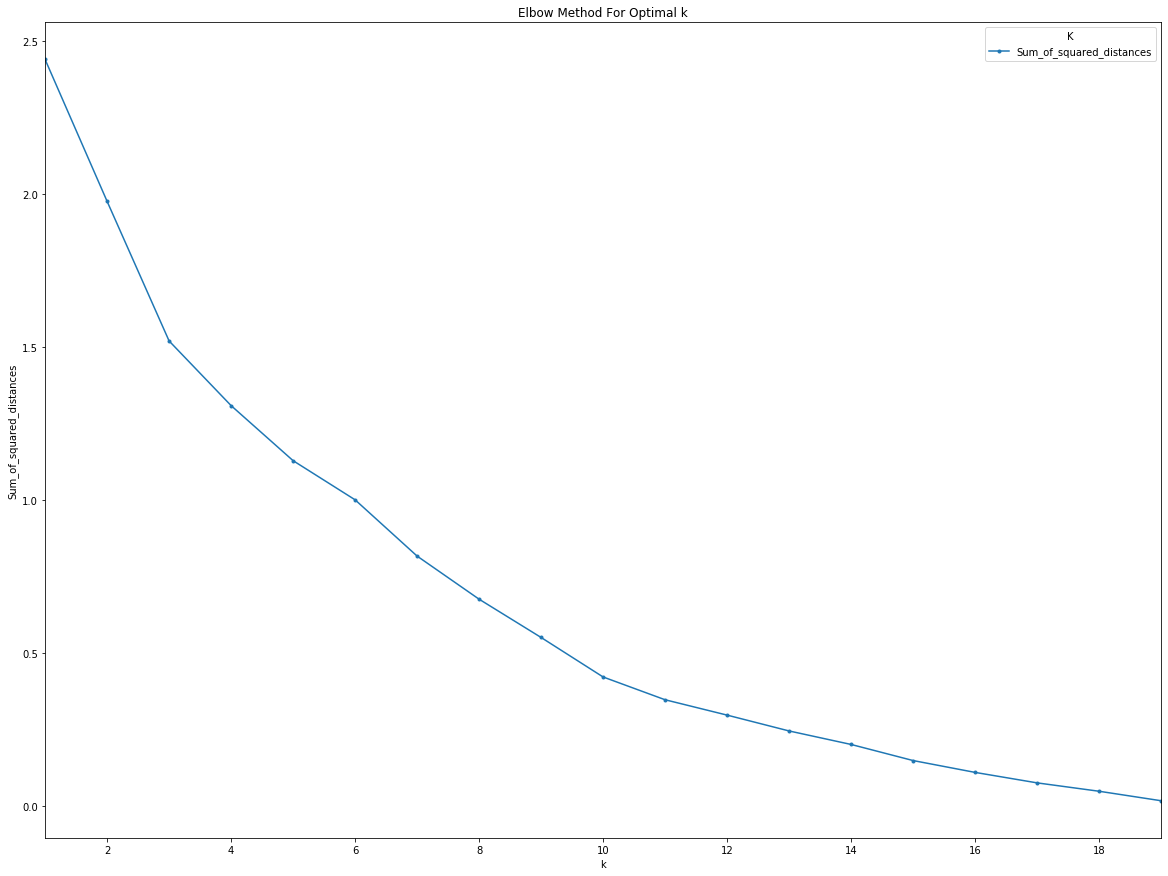

In [0]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that our best suitable K value is 6.

In [0]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 5, 0, 0, 0, 0, 0, 0, 0, 4], dtype=int32)

# Segment the neighborhoods by population's nationalities and most common venues

### Now we are going to create a new df that contains the cluster labels as well as the top 10 venues per neighborhood

In [0]:
london_merged = df.merge(neighborhoods_venues_sorted, how='inner', left_on='London Borough', right_on='Neighborhood')
london_merged['Cluster Labels'] = kmeans.labels_
london_merged

London Borough  Indian Population  Pakistani Population  \
0                 Newham              42484                 30307   
1              Redbridge              45660                 31051   
2                  Brent              58017                 14381   
3          Tower Hamlets               6787                  2442   
4                 Harrow              63051                  7797   
5                 Ealing              48240                 14711   
6               Hounslow              48161                 13676   
7             Hillingdon              36795                  9200   
8                 Barnet              27920                  5344   
9                Croydon              24660                 10865   
10        Waltham Forest               9134                 26347   
11                Merton               8106                  7337   
12                Camden               6083                  1489   
13               Enfield              11648                  2594   
14            Wandsworth               8642                  9718   
15           Westminster               7213                  2328   
16             Greenwich               7836                  2594   
17  Barking and Dagenham               7436                  8007   
18             Southwark               5819                  1623   
19  Kingston Upon Thames               6325                  3009   

    Bangladeshi Population  Chinese Population  Other Asian Population  \
0                    37262                3930                   19912   
1                    16011                3000                   20781   
2                     1749                3250                   28589   
3                    81377                8109                    5786   
4                     1378                2629                   26953   
5                     1786                4132                   31570   
6                     2189                2405                   20826   
7                     2639                2889                   17730   
8                     2215                8259                   22180   
9                     2570                3925                   17607   
10                    4632                2579                   11697   
11                    2216                2618                   15866   
12                   12503                6493                    8878   
13                    5599                2588                   12464   
14                    1493                3715                    9770   
15                    6299                5917                   10105   
16                    1645                5061                   12758   
17                    7701                1315                    5135   
18                    3912                8074                    7764   
19                     892                2883                   13043   

    Total Asian Population          Neighborhood      1st Most Common Venue  \
0                   133895                Newham              Grocery Store   
1                   116503             Redbridge                Supermarket   
2                   105986                 Brent                Supermarket   
3                   104501         Tower Hamlets                Coffee Shop   
4                   101808                Harrow                Coffee Shop   
5                   100439                Ealing                      Hotel   
6                    87257              Hounslow  Middle Eastern Restaurant   
7                    69253            Hillingdon                     Bakery   
8                    65918                Barnet                       Café   
9                    59627               Croydon                Coffee Shop   
10                   54389        Waltham Forest              Grocery Store   
11                   36143                Merton         

### Adding coordinates

In [0]:
london_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
london_merged['Latitude'] = london_merged['Latitude'].astype(float)
london_merged['Longitude'] = london_merged['Longitude'].astype(float)
london_merged

London Borough  Indian Population  Pakistani Population  \
0                 Newham              42484                 30307   
1              Redbridge              45660                 31051   
2                  Brent              58017                 14381   
3          Tower Hamlets               6787                  2442   
4                 Harrow              63051                  7797   
5                 Ealing              48240                 14711   
6               Hounslow              48161                 13676   
7             Hillingdon              36795                  9200   
8                 Barnet              27920                  5344   
9                Croydon              24660                 10865   
10        Waltham Forest               9134                 26347   
11                Merton               8106                  7337   
12                Camden               6083                  1489   
13               Enfield              11648                  2594   
14            Wandsworth               8642                  9718   
15           Westminster               7213                  2328   
16             Greenwich               7836                  2594   
17  Barking and Dagenham               7436                  8007   
18             Southwark               5819                  1623   
19  Kingston Upon Thames               6325                  3009   

    Bangladeshi Population  Chinese Population  Other Asian Population  \
0                    37262                3930                   19912   
1                    16011                3000                   20781   
2                     1749                3250                   28589   
3                    81377                8109                    5786   
4                     1378                2629                   26953   
5                     1786                4132                   31570   
6                     2189                2405                   20826   
7                     2639                2889                   17730   
8                     2215                8259                   22180   
9                     2570                3925                   17607   
10                    4632                2579                   11697   
11                    2216                2618                   15866   
12                   12503                6493                    8878   
13                    5599                2588                   12464   
14                    1493                3715                    9770   
15                    6299                5917                   10105   
16                    1645                5061                   12758   
17                    7701                1315                    5135   
18                    3912                8074                    7764   
19                     892                2883                   13043   

    Total Asian Population          Neighborhood      1st Most Common Venue  \
0                   133895                Newham              Grocery Store   
1                   116503             Redbridge                Supermarket   
2                   105986                 Brent                Supermarket   
3                   104501         Tower Hamlets                Coffee Shop   
4                   101808                Harrow                Coffee Shop   
5                   100439                Ealing                      Hotel   
6                    87257              Hounslow  Middle Eastern Restaurant   
7                    69253            Hillingdon                     Bakery   
8                    65918                Barnet                       Café   
9                    59627               Croydon                Coffee Shop   
10                   54389        Waltham Forest              Grocery Store   
11                   36143                Merton         

### Now, let's visualize our clusters

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now we can examine our clusters

#### Cluster One:

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
4                 Harrow              63051                  7797   
2                  Brent              58017                 14381   
5                 Ealing              48240                 14711   
6               Hounslow              48161                 13676   
7             Hillingdon              36795                  9200   
8                 Barnet              27920                  5344   
14            Wandsworth               8642                  9718   
11                Merton               8106                  7337   
16             Greenwich               7836                  2594   
3          Tower Hamlets               6787                  2442   
19  Kingston Upon Thames               6325                  3009   

    Bangladeshi Population  Chinese Population  Other Asian Population  \
4                     1378                2629                   26953   
2                     1749                3250                   28589   
5                     1786                4132                   31570   
6                     2189                2405                   20826   
7                     2639                2889                   17730   
8                     2215                8259                   22180   
14                    1493                3715                    9770   
11                    2216                2618                   15866   
16                    1645                5061                   12758   
3                    81377                8109                    5786   
19                     892                2883                   13043   

    Total Asian Population          Neighborhood      1st Most Common Venue  \
4                   101808                Harrow                Coffee Shop   
2                   105986                 Brent                Supermarket   
5                   100439                Ealing                      Hotel   
6                    87257              Hounslow  Middle Eastern Restaurant   
7                    69253            Hillingdon                     Bakery   
8                    65918                Barnet                       Café   
14                   33338            Wandsworth                        Pub   
11                   36143                Merton              Grocery Store   
16                   29894             Greenwich                       Park   
3                   104501         Tower Hamlets                Coffee Shop   
19                   26152  Kingston Upon Thames                       Café   

   2nd Most Common Venue       3rd Most Common Venue 4th Most Common Venue  \
4         Clothing Store                 Pizza Place                   Gym   
2            IT Services                 Bus Station            Food Truck   
5   Fast Food Restaurant                 Supermarket         Grocery Store   
6            Auto Garage                 Pizza Place         Grocery Store   
7     Chinese Restaurant  Construction & Landscaping     Martial Arts Dojo   
8               Bus Stop               Women's Store        Cosmetics Shop   
14         Grocery Store                        Café           Coffee Shop   
11                Bakery                        Café                  Park   
16    Chinese Restaurant              Ice Cream Shop               Brewery   
3          Track Stadium   Middle Eastern Restaurant            Canal Lock   
19           Coffee Shop              Clothing Store                Bakery   

   5th Most Common Venue 6th Most Common Venue   7th Most Common Venue  \
4          Women's Store        Sandwich Place                    Café   
2               Bus Stop                  Café    Fast Food Restaurant   
5            Coffee Shop                Bakery          Farmers Market   
6      Indian Restaurant          Dessert Shop                   Diner   
7         Breakfast Spot     Fish & 

#### Cluster Two:

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
0         Newham              42484                 30307   

   Bangladeshi Population  Chinese Population  Other Asian Population  \
0                   37262                3930                   19912   

   Total Asian Population Neighborhood 1st Most Common Venue  \
0                  133895       Newham         Grocery Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café     Fish & Chips Shop          Home Service   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                  Park         Women's Store      Department Store   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0          Dessert Shop                 Diner       Doner Restaurant   

   Cluster Labels  Latitude  Longitude  
0               1   51.5255     0.0352

#### Cluster Three:

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
15    Westminster               7213                  2328   

    Bangladeshi Population  Chinese Population  Other Asian Population  \
15                    6299                5917                   10105   

    Total Asian Population Neighborhood 1st Most Common Venue  \
15                   31862  Westminster                 Hotel   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
15           Coffee Shop        Sandwich Place      Sushi Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
15               Theater           Salad Place  Gym / Fitness Center   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
15     Indian Restaurant             Hotel Bar              Juice Bar   

    Cluster Labels  Latitude  Longitude  
15               2   51.4975    -0.1357

#### Cluster Four:

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
13               Enfield              11648                  2594   
10        Waltham Forest               9134                 26347   
17  Barking and Dagenham               7436                  8007   
12                Camden               6083                  1489   
18             Southwark               5819                  1623   

    Bangladeshi Population  Chinese Population  Other Asian Population  \
13                    5599                2588                   12464   
10                    4632                2579                   11697   
17                    7701                1315                    5135   
12                   12503                6493                    8878   
18                    3912                8074                    7764   

    Total Asian Population          Neighborhood 1st Most Common Venue  \
13                   34893               Enfield                   Pub   
10                   54389        Waltham Forest         Grocery Store   
17                   29594  Barking and Dagenham                  Lake   
12                   35446                Camden             Gastropub   
18                   27192             Southwark                   Pub   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
13           Coffee Shop            Restaurant         Auto Workshop   
10                   Pub           Coffee Shop          Concert Hall   
17                  Park         Women's Store            Food Court   
12                Bakery           Pizza Place           Coffee Shop   
18              Building                  Café            Skate Park   

            5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
13                   Tennis Court            Donut Shop  Fast Food Restaurant   
10  Vegetarian / Vegan Restaurant                 Field                   Gym   
17               Department Store          Dessert Shop                 Diner   
12                           Café   American Restaurant          Burger Joint   
18                           Park                  Lake     Fish & Chips Shop   

   8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  \
13        Farmers Market      Falafel Restaurant      Electronics Store   
10                 Trail  Thrift / Vintage Store            Pizza Place   
17      Doner Restaurant              Donut Shop      Electronics Store   
12  Gym / Fitness Center               Wine Shop      French Restaurant   
18  Fast Food Restaurant          Farmers Market     Falafel Restaurant   

    Cluster Labels  Latitude  Longitude  
13               3   51.6636    -0.1043  
10               3   51.5886    -0.0118  
17               3   51.5465     0.1293  
12               3   51.5517    -0.1588  
18               3   51.4834    -0.0821

#### Cluster Five

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
9        Croydon              24660                 10865   

   Bangladeshi Population  Chinese Population  Other Asian Population  \
9                    2570                3925                   17607   

   Total Asian Population Neighborhood 1st Most Common Venue  \
9                   59627      Croydon           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
9              Platform        Clothing Store                   Pub   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
9             Bookstore                 Hotel                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
9      Asian Restaurant      Sushi Restaurant  Portuguese Restaurant   

   Cluster Labels  Latitude  Longitude  
9               4   51.3762    -0.0982

#### Cluster Six

In [0]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)



London Borough  Indian Population  Pakistani Population  \
1      Redbridge              45660                 31051   

   Bangladeshi Population  Chinese Population  Other Asian Population  \
1                   16011                3000                   20781   

   Total Asian Population Neighborhood 1st Most Common Venue  \
1                  116503    Redbridge           Supermarket   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1                   Pub              Pharmacy  Fast Food Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
1                  Café        Sandwich Place                  Park   

  8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  \
1           Coffee Shop  Middle Eastern Restaurant       Greek Restaurant   

   Cluster Labels  Latitude  Longitude  
1               5   51.5901     0.0819

# Conclusions:

As far as we are able to see with this data, the highest amount of Indian population is located at Harrow represented in cluster 1.

If a deeper exam is performed into this cluster, it is noticeable that the living population in here ranks it the 5th most Asian inhabited borough. Apart of this fact, a strange closeness to Indian food can be found as the 8th most prominent venue in here is Middle Eastern restaurant which, while not being an Indian restaurant is the closest match to an Indian cuisine restaurant.

By following this logic, if we would like to open a new Indian restaurant in the city or any kind of restaurant in fact, it would only be necessary to find a where are the restaurants similar the one we want to open, study the population in that area, and find similar clusters of population in the city that don't have yet or have very few restaurants like the one we would like to open.

In this example, clusters 1 could make a good match for our target population. Looking at the venues in this cluster, it is possible to find two Indian restaurants, and a good bunch of Middle Eastern restaurants and coffee shops. So, in this cluster, it is possible to state that the existing restaurants matches the population's nationalities and tastes.

In conclusion, and taking into consideration the explanations given above as well as the data, it is highly possible that cluster 1 could be a good place to open our Indian restaurants. As explained above, the same logic could apply to open other kind of restaurants or business in any other area of the city. It is only necessary to examine the existing businesses in our target area, and study the population, then compare these 2 factors with the same ones in areas where there are existing business like the one we want to open, and then verify if the matching is correct.